# Tensorflow Implementation of VGG Face Detector

Objective: Convert the VGG face descriptor model http://www.robots.ox.ac.uk/~vgg/software/vgg_face/ to Tensorflow format.
<br>
Output: Final Tensorflow classifier model trained on the gender dataset

In [1]:
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Convolution2D, MaxPooling2D, Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization

Using TensorFlow backend.


## Read .mat file for Model Description

In [2]:
def load_mat():
    mat = sio.loadmat('data/vgg_face.mat', struct_as_record=False)
    return mat

mat = load_mat()
net = mat['net'][0][0]
mat_model = net.layers
mat_model_layers = mat_model[0]
num_mat_layers = mat_model_layers.shape[0]
for layer in mat_model_layers:
    print(layer[0][0].name)

['conv1_1']
['relu1_1']
['conv1_2']
['relu1_2']
['pool1']
['conv2_1']
['relu2_1']
['conv2_2']
['relu2_2']
['pool2']
['conv3_1']
['relu3_1']
['conv3_2']
['relu3_2']
['conv3_3']
['relu3_3']
['pool3']
['conv4_1']
['relu4_1']
['conv4_2']
['relu4_2']
['conv4_3']
['relu4_3']
['pool4']
['conv5_1']
['relu5_1']
['conv5_2']
['relu5_2']
['conv5_3']
['relu5_3']
['pool5']
['fc6']
['relu6']
['dropout6']
['fc7']
['relu7']
['dropout7']
['fc8']
['softmax']


## VGG Architecture Implementation
We can read the model described in the .mat file and build our tensorflow/keras model using clues. This way we can avoid reproducing it by hand. Additionally, this saves us the trouble of later applying the model weights from the .mat file to our tensorflow/keras model.

In [3]:
def vgg_tf():
    model = Sequential()

    for i in range(num_mat_layers):
        mat_model_layer = mat_model_layers[i][0][0].name[0]
        if mat_model_layer.find("conv") == 0 or mat_model_layer.find("fc") == 0:
            weights = mat_model_layers[i][0,0].weights
            weights_shape = weights[0][0].shape
            filter_x = weights_shape[0]; filter_y = weights_shape[1]
            number_of_filters = weights_shape[3]

            if mat_model_layer.find("conv") == 0:
                print("ZeroPadding2D((1,1))")
                if i == 0:
                    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
                else:
                    model.add(ZeroPadding2D((1,1)))

            print("Convolution2D(",number_of_filters,", (",filter_x,", ",filter_y,"), name='",mat_model_layer,"')")
            model.add(Convolution2D(number_of_filters, (filter_x, filter_y), name= mat_model_layer))

        else:
            if mat_model_layer.find("relu") == 0:
                print("Activation('relu', name=",mat_model_layer)
                model.add(Activation('relu', name=mat_model_layer))
            elif mat_model_layer.find("dropout") == 0:
                print("Dropout(0.5, name=",mat_model_layer,")")
                model.add(Dropout(0.5, name=mat_model_layer))
            elif mat_model_layer.find("pool") == 0:
                print("MaxPooling2D((2,2), strides=(2,2), name=",mat_model_layer,")")
                model.add(MaxPooling2D((2,2), strides=(2,2), name=mat_model_layer))
            elif mat_model_layer.find("softmax") == 0:
                print("Activation('softmax', name=",mat_model_layer,")")
                model.add(Activation('softmax', name=mat_model_layer))
            else:
                print("-->",mat_model_layer)
    return model

Save model to .h5 file for use later.

In [4]:
model_ = vgg_tf()
model_.save('data/vgg_face.h5')
model = Model(inputs=model_.layers[0].input,outputs=model_.layers[-2].output)

ZeroPadding2D((1,1))
Convolution2D( 64 , ( 3 ,  3 ), name=' conv1_1 ')
Activation('relu', name= relu1_1
ZeroPadding2D((1,1))
Convolution2D( 64 , ( 3 ,  3 ), name=' conv1_2 ')
Activation('relu', name= relu1_2
MaxPooling2D((2,2), strides=(2,2), name= pool1 )
ZeroPadding2D((1,1))
Convolution2D( 128 , ( 3 ,  3 ), name=' conv2_1 ')
Activation('relu', name= relu2_1
ZeroPadding2D((1,1))
Convolution2D( 128 , ( 3 ,  3 ), name=' conv2_2 ')
Activation('relu', name= relu2_2
MaxPooling2D((2,2), strides=(2,2), name= pool2 )
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_1 ')
Activation('relu', name= relu3_1
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_2 ')
Activation('relu', name= relu3_2
ZeroPadding2D((1,1))
Convolution2D( 256 , ( 3 ,  3 ), name=' conv3_3 ')
Activation('relu', name= relu3_3
MaxPooling2D((2,2), strides=(2,2), name= pool3 )
ZeroPadding2D((1,1))
Convolution2D( 512 , ( 3 ,  3 ), name=' conv4_1 ')
Activation('relu', name= relu4_1
ZeroPadding2D((

## Load Dataset

In [125]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

In [126]:
def pad(img):
    ht, wd, cc= img.shape
    ww = 224
    hh = 224
    color = (0,0,0)
    result = np.full((hh,ww,cc), color, dtype=np.uint8)
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2
    result[yy:yy+ht, xx:xx+wd] = img
    return result

def load_img_file(path, model):
    img = Image.open(path)
#     img = load_img(path)
    x = img_to_array(img) 
    x = pad(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = model(x)
    return x

def load_data(path, model):
    x = []
    y = []
    labels = {}
    folders = os.listdir(path)
    for i in tqdm(range(len(folders))):
        labels[i] = folders[i]
        label_path = path + '/' + folders[i]
        images = os.listdir(label_path)
        for image in images:
            img = load_img_file(label_path + '/' + image, model)
            x.append(np.squeeze(K.eval(img)).tolist())
            y.append(i)
    return np.array(x), np.array(y), labels

In [127]:
X_train = y_train = labels = None
try:
    X_train = np.load('data/combined/X_train.npy', allow_pickle=True)
    y_train = np.load('data/combined/y_train.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_train, y_train, labels = load_data('data/combined/aligned', model)
    np.save('data/combined/X_train', X_train)
    np.save('data/combined/y_train', y_train)
    np.save('data/combined/labels', labels)

In [128]:
X_test = y_test = None
try:
    X_test = np.load('data/combined/X_test.npy', allow_pickle=True)
    y_test = np.load('data/combined/y_test.npy', allow_pickle=True)
    labels = np.load('data/combined/labels.npy', allow_pickle=True)[()]
except:
    X_test, y_test, labels = load_data('data/combined/valid', model)
    np.save('data/combined/X_test', X_test)
    np.save('data/combined/y_test', y_test)

In [129]:
print(labels)

{0: '01_F', 1: '01_M', 2: '02_F', 3: '02_M', 4: '03_F', 5: '03_M', 6: '04_F', 7: '04_M', 8: '05_F', 9: '05_M', 10: '06_F', 11: '06_M', 12: '07_F', 13: '07_M', 14: '08_F', 15: '08_M', 16: '09_F', 17: '09_M', 18: '10_F', 19: '10_M', 20: '11_F', 21: '11_M', 22: '12_F', 23: '12_M', 24: '13_F', 25: '13_M', 26: '14_F', 27: '14_M', 28: '15_F', 29: '15_M', 30: '16_F', 31: '16_M', 32: '17_F', 33: '17_M', 34: '18_F', 35: '18_M', 36: '19_F', 37: '19_M', 38: '20_F', 39: '20_M', 40: '21_F', 41: '21_M', 42: '22_F', 43: '22_M', 44: '23_F', 45: '23_M', 46: '24_F', 47: '24_M', 48: '25_F', 49: '25_M', 50: '26_F', 51: '26_M', 52: '27_F', 53: '27_M', 54: '28_F', 55: '28_M', 56: '29_F', 57: '29_M', 58: '30_F', 59: '30_M', 60: '31_F', 61: '31_M', 62: '32_F', 63: '32_M', 64: '33_F', 65: '33_M', 66: '34_F', 67: '34_M', 68: '35_F', 69: '35_M', 70: '36_F', 71: '36_M', 72: '37_F', 73: '37_M', 74: '38_F', 75: '38_M', 76: '39_F', 77: '39_M', 78: '40_F', 79: '40_M', 80: '41_F', 81: '41_M', 82: '42_F', 83: '42_M', 8

## Construct Classifier 

In [36]:
def classier_model(input_dim, num_classes):
    classifier = Sequential()
    classifier.add(Dense(num_classes))
    classifier.add(Activation('softmax'))
    classifier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam', metrics=['accuracy'])
    return classifier

## Train Classifier

In [37]:
from matplotlib import pyplot as plt

def plotter(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Gender Classification

Train classifier for gender classification (of all ages together).

In [40]:
y_train_gender = np.copy(y_train)
y_test_gender = np.copy(y_test)
y_train_gender[y_train_gender % 2 == 0] = 0
y_train_gender[y_train_gender % 2 != 0] = 1
y_test_gender[y_test_gender % 2 == 0] = 0
y_test_gender[y_test_gender % 2 != 0] = 1

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_gender, batch_size=16, epochs=100, validation_data=(X_test, y_test_gender))
classifier.save('data/gender_classifier.h5')

Epoch 1/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.6514 - accuracy: 0.6198 - val_loss: 0.6154 - val_accuracy: 0.6802
Epoch 2/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.6067 - accuracy: 0.6791 - val_loss: 0.5859 - val_accuracy: 0.7050
Epoch 3/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5834 - accuracy: 0.7019 - val_loss: 0.5683 - val_accuracy: 0.7191
Epoch 4/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5674 - accuracy: 0.7135 - val_loss: 0.5589 - val_accuracy: 0.7205
Epoch 5/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5564 - accuracy: 0.7213 - val_loss: 0.5467 - val_accuracy: 0.7324
Epoch 6/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5474 - accuracy: 0.7294 - val_loss: 0.5500 - val_accuracy: 0.7186
Epoch 7/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.5403 - accuracy: 0.7351 - val_loss: 0.5363 - val_ac

1840/1840 [==============================] - 3s 1ms/step - loss: 0.4566 - accuracy: 0.7889 - val_loss: 0.4691 - val_accuracy: 0.7794
Epoch 58/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4557 - accuracy: 0.7888 - val_loss: 0.4801 - val_accuracy: 0.7713
Epoch 59/100
1840/1840 [==============================] - 2s 1ms/step - loss: 0.4562 - accuracy: 0.7894 - val_loss: 0.4680 - val_accuracy: 0.7810
Epoch 60/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.4550 - accuracy: 0.7910 - val_loss: 0.4682 - val_accuracy: 0.7789
Epoch 61/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.4548 - accuracy: 0.7906 - val_loss: 0.4689 - val_accuracy: 0.7778
Epoch 62/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.4534 - accuracy: 0.7902 - val_loss: 0.4659 - val_accuracy: 0.7808
Epoch 63/100
1840/1840 [==============================] - 3s 1ms/step - loss: 0.4541 - accuracy: 0.7881 - val_loss: 0.4680 - val_accuracy

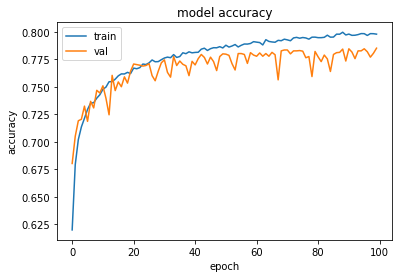

In [41]:
plotter(history)

### Age Group Classification
Train classifier to recognize the different age groups (not taking into account gender).

In [42]:
def labels(y):
    t = 0
    for i in range(0, 140, 2):
        y[ y == i ] = t
        y[ y == i+1 ] = t
        t += 1
    return y

y_train_age = labels(np.copy(y_train))
y_test_age = labels(np.copy(y_test))
print(y_train_age)

classifier = classier_model(2622, 70)
history = classifier.fit(X_train, y_train_age, batch_size=16, epochs=100, validation_data=(X_test, y_test_age))
classifier.save('data/age_classifier.h5')

[ 0  0  0 ... 69 69 69]
Epoch 1/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2780 - accuracy: 0.0179 - val_loss: 4.2543 - val_accuracy: 0.0255
Epoch 2/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2299 - accuracy: 0.0243 - val_loss: 4.2395 - val_accuracy: 0.0280
Epoch 3/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.2048 - accuracy: 0.0267 - val_loss: 4.1993 - val_accuracy: 0.0277
Epoch 4/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1837 - accuracy: 0.0318 - val_loss: 4.2040 - val_accuracy: 0.0304
Epoch 5/100
1840/1840 [==============================] - 3s 2ms/step - loss: 4.1655 - accuracy: 0.0318 - val_loss: 4.1894 - val_accuracy: 0.0253
Epoch 6/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1495 - accuracy: 0.0357 - val_loss: 4.1843 - val_accuracy: 0.0326
Epoch 7/100
1840/1840 [==============================] - 3s 1ms/step - loss: 4.1343 - accuracy: 0.0354 - v

1840/1840 [==============================] - 3s 1ms/step - loss: 3.7694 - accuracy: 0.0923 - val_loss: 4.0269 - val_accuracy: 0.0516
Epoch 58/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7657 - accuracy: 0.0971 - val_loss: 4.0388 - val_accuracy: 0.0454
Epoch 59/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7590 - accuracy: 0.0973 - val_loss: 4.0404 - val_accuracy: 0.0467
Epoch 60/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7536 - accuracy: 0.0984 - val_loss: 4.0382 - val_accuracy: 0.0448
Epoch 61/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7510 - accuracy: 0.0976 - val_loss: 4.0208 - val_accuracy: 0.0454
Epoch 62/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7456 - accuracy: 0.1015 - val_loss: 4.0495 - val_accuracy: 0.0454
Epoch 63/100
1840/1840 [==============================] - 3s 1ms/step - loss: 3.7432 - accuracy: 0.1007 - val_loss: 4.0432 - val_accuracy

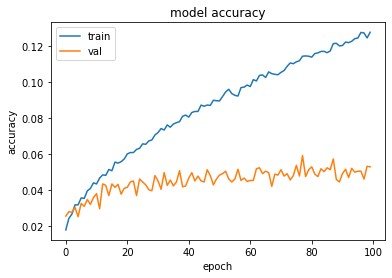

In [43]:
plotter(history)

### Gender and Age Group Classification
Train classifier to recognize gender across 7 different age groups (1-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70). Each age group has 2 genders.

In [ ]:
y_train_agegender = y_train
y_test_agegender = y_test

def age_gender_label(arr):
    

classifier = classier_model(2622, 2)
history = classifier.fit(X_train, y_train_agegender, batch_size=16, epochs=100, validation_data=(X_test, y_test_agegender))

Train classifier on each class.

480
480
60
60


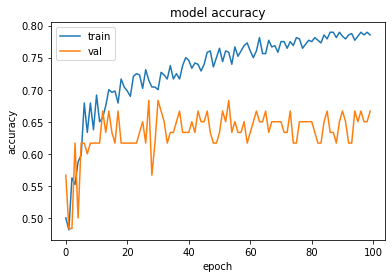

480
480
60
60


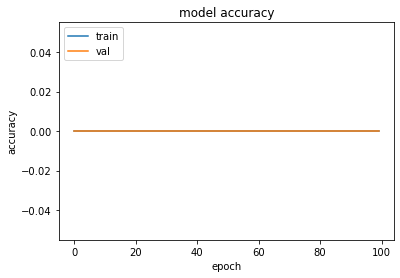

424
424
55
55


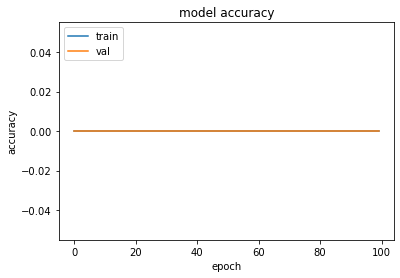

424
424
54
54


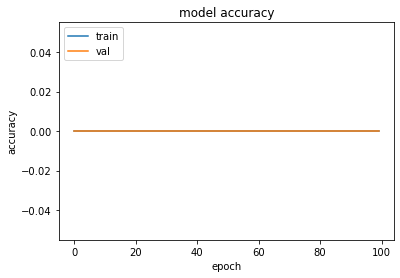

423
423
54
54


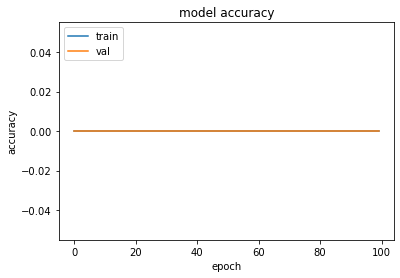

423
423
54
54


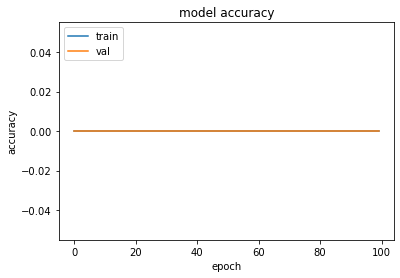

402
402
51
51


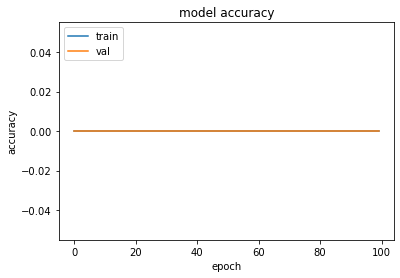

402
402
50
50


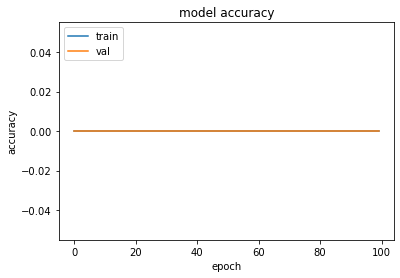

402
402
50
50


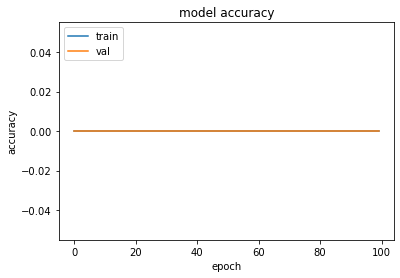

402
402
50
50


In [ ]:
for i in range(0, 70, 2):
    classifier = classier_model(2622, 2)
    female_train = np.where(y_train == i)[0]
    female_test = np.where(y_test == i)[0]
    male_train = np.where(y_train == i+1)[0]
    male_test = np.where(y_test == i+1)[0]

    X_train_label = np.concatenate((X_train[female_train], X_train[male_train]), axis=0)
    y_train_label = np.concatenate((y_train[female_train], y_train[male_train]), axis=0) 
    X_test_label = np.concatenate((X_test[female_test], X_test[male_test]), axis=0)
    y_test_label = np.concatenate((y_test[female_test], y_test[male_test]), axis=0)
    print(len(X_train_label))
    print(len(y_train_label))
    print(len(X_test_label))
    print(len(y_test_label))

    history = classifier.fit(X_train_label, y_train_label, epochs=100, validation_data=(X_test_label,y_test_label), verbose=0)
    plotter(history)

Train classifier on all the classes.

In [ ]:
classifier = classier_model(2622, 140)
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

## Results

## Mom Prediction

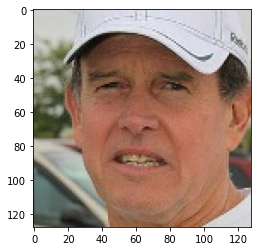

In [157]:
import matplotlib.image as mpimg
img=mpimg.imread('data/b.jpg')
imgplot = plt.imshow(img)
plt.show()

In [158]:
img = load_img_file('data/b.jpg', model)
# img = np.squeeze(K.eval(img)).tolist()

Now lets see if the classifier can accurately detect my mothers gender!

In [159]:
from keras.models import load_model

In [160]:
gender = load_model('data/gender_classifier.h5')
pred = gender.predict(img)
gender_pred = np.argmax(pred)
gender_pred = "Male" if gender_pred == 1 else "Female"
print("Predicted gender is: " + gender_pred + "!")

Predicted gender is: Female!
